In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
swarm = gd.GMR22H05_swarm
fly = swarm.flies[4]

In [3]:
sigs = fly.get_pkl_data('nnls_fits_no_bk_dF_F_sigs.cpkl')
exp_record = fly.get_expmnt(fly.list_expmnts()[0])

In [4]:
import muscle_model as mm
confocal_model = mm.GeometricModel(filepath = '../imaging_post_processing/model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)
import cv2
import cPickle
pkname = fly.fly_path + '/basis_fits.cpkl'
fly_frame = mm.Frame();fly_frame.load(pkname)

def get_line_database(line_name):
    #print line_name
    import cPickle
    f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database(line_name)
    muscle_names = list()
    for key in line_database[line_name].keys():
        if line_database[line_name][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    muscles = [m for m in muscle_names if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    return muscles

def frmt_axis(r,c,row,col):
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    plb.gca().set_ybound(-0.1,1.8)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    if (c == 0):
        plb.gca().spines['left'].set_visible(True)
        plb.gca().set_ylabel(row)
    if (r == len(plot_sigs)-1):
        plb.gca().spines['bottom'].set_visible(True)
        [x.set_visible(True) for x in plb.gca().get_xticklabels()]
        [x.set_visible(True) for x in plb.gca().get_xticklines()[::2]]
    if (r == 0):
        pass
        #plb.gca().set_title(col)
    if ('amp' in row):
        plb.gca().set_ybound(-90,90)
    if ('freq' in row):
        plb.gca().set_ybound(0,250)
    if ('stripe' in row):
        plb.gca().set_ybound(0,2*pi)
    plb.gca().set_xbound(10,90)

def kill_spines():
    plb.gca().spines['top'].set_visible(False)
    plb.gca().spines['right'].set_visible(False)
    plb.gca().spines['left'].set_visible(False)
    plb.gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]#.set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]
    plb.gca().set_ybound(275,1024)
    plb.gca().set_xbound(0,800)
    
def warp_fly_image(fly_path,img,s = 1):
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_model():
    muscles = get_muscle_list('22H05')
    #get the mask of all the muscles for fit
    masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
    #create the model using only the muscles that express in a given line
    model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])
    return model

In [5]:
plot_sigs = ['wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

In [6]:
strt_time = 15
end_time = 95

times = sigs['times']-strt_time
strt_idx = np.argwhere(sigs['times']>strt_time)[0]
end_idx = np.argwhere(sigs['times']<end_time)[-1]
trng = np.arange(strt_idx,end_idx)
imgs = np.array(exp_record['tiff_data']['images'])[trng]
flight_mask = sigs['wb_frequency'][trng] > 20

xpos = np.array(exp_record['tiff_data']['axon_framebase']['Xpos'])[trng]*2*pi/10 * flight_mask
lwing_angles = np.rad2deg(np.array(exp_record['tiff_data']['axon_framebase']['Ph0'])[trng]/5) 
rwing_angles = np.rad2deg(np.array(exp_record['tiff_data']['axon_framebase']['Ph1'])[trng]/5) 
lmr_angles = np.rad2deg(np.array(exp_record['tiff_data']['axon_framebase']['Ph2'])[trng]/5)

lwing_angles[~flight_mask] = -90
rwing_angles[~flight_mask] = -90
lmr_angles[~flight_mask] = -90

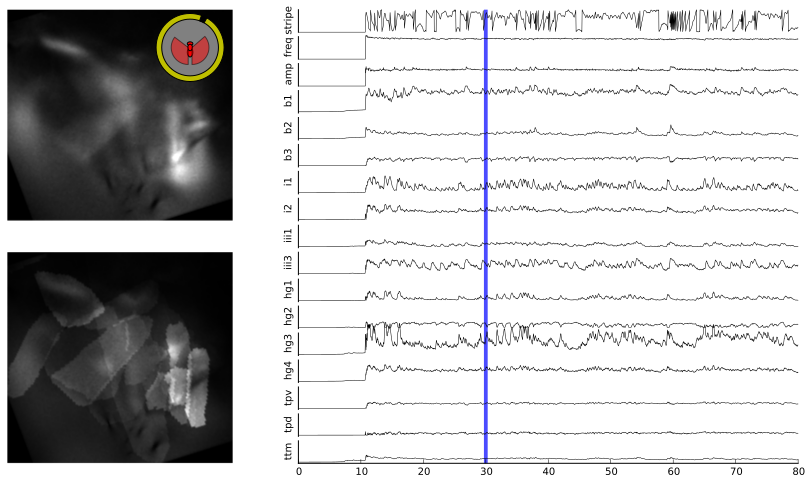

In [7]:
import numpy as np
w = 13
h = 7
aspect = w/float(h)
fig = plb.figure(figsize = (w,h))

plot_sigs = ['Xpos','wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

from matplotlib.gridspec import GridSpec
gs = GridSpec(len(plot_sigs),10)
bkplot = fig.add_subplot(gs[:,4:])
kill_spines()

gamma = lambda x: x**1.6
vmax = gamma(80)

kwargs = {'color':'k','lw':0.5,'clip_on':False}

strt = 0
hlt_rng = [strt-0.3,strt+0.3]

ptch = plb.axvspan(hlt_rng[0],hlt_rng[1],lw =0,alpha = 0.7)
bkplot.set_xbound(0,80)

plotpans = [fig.add_subplot(gs[i,4:]) for i in range(len(plot_sigs))]

patch_list = list()
for i,pp,sig in zip(range(len(plot_sigs)),plotpans,plot_sigs):
    plb.axes(pp)
    if 'Ph1' in sig:
        plb.plot(times[trng],rwing_angles,**kwargs)
        frmt_axis(i,0,'amp',None)
    elif 'Xpos' in sig:
        plb.plot(times[trng],xpos,**kwargs)
        frmt_axis(i,0,'stripe',None)
    elif 'wb_frequency' in sig:
        plb.plot(times[trng],sigs[sig][trng],**kwargs)
        frmt_axis(i,0,'freq',None)
    else:
        try:
            plb.plot(times[trng],sigs[sig][trng],**kwargs)
            frmt_axis(i,0,sig,None)
        except KeyError:
            print i
[ax.set_xbound(0,80) for ax in plotpans]


img_idx = np.squeeze(np.argwhere(times[trng]>hlt_rng[0]))[0]

data_plot = plb.subplot(gs[:len(plot_sigs)/2,:4])
data_img = gamma(imgs[img_idx])
data_img = warp_fly_image(fly.fly_path,data_img)
data_img_handle = plb.imshow(data_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()
    
model = get_model()
model_plot = plb.subplot(gs[1+len(plot_sigs)/2:,:4])
##get the baseline epoch
f = open(fly.fly_path + 'epoch_data.cpkl')
import cPickle
baseline_range = cPickle.load(f)['baseline_F']
f.close()
baseln = np.mean(exp_record['tiff_data']['images'][baseline_range],axis = 0)

#reconstruct the fit vector
fits_reconst = np.array([sigs[m] for m in get_muscle_list('22H05')])
model_img = gamma((np.dot(model.T,fits_reconst[:,trng][:,img_idx]).reshape(np.shape(imgs[0]))*baseln)+baseln)
model_img = warp_fly_image(fly.fly_path,model_img)
model_img_handle = plb.imshow(model_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()

fig.subplots_adjust(subplots_adjust(bottom=0.05, right=0.95, top=0.95,left =0.05))

ptch_start = ptch.xy[:,0].copy()

#####
#####
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
fly_diagram = dict()
inset_axes = fig.add_axes([.26,.80,.15/aspect,.15])

wing_len = 9.0
theta_r = pi/4
theta_l = pi/4.3
stripe_center = 90
swidth = 3
arena_rad = 2*wing_len 
base = mpatches.Circle((0,0),arena_rad - swidth,facecolor = 'gray')
panels = mpatches.Circle((0,0),arena_rad,facecolor = 'y')
body = mpatches.Ellipse((0,0),2.5,3.5,facecolor = 'r')
abdomin = mpatches.Ellipse((0,-2.5),3,5,facecolor = 'r')
head = mpatches.Ellipse((0,2.0),3,2,facecolor = 'r')
stripe = mpatches.Wedge((0,0),arena_rad,stripe_center-5,stripe_center+5,width = swidth,color = 'k')
rwing = mpatches.Wedge((1,0),wing_len,-90,rad2deg(theta_r),alpha = 0.5,facecolor = 'r')
lwing = mpatches.Wedge((-1,0),wing_len,180-rad2deg(theta_l),-90,alpha = 0.5,facecolor = 'r')
fly_diagram.update({'base':base,'panels':panels,
                    'body':body,'abdomin':abdomin,
                    'head':head,'stripe':stripe,
                    'rwing':rwing,'lwing':lwing})
inset_axes.add_patch(panels)
inset_axes.add_patch(base)
inset_axes.add_patch(abdomin)
inset_axes.add_patch(head)
inset_axes.add_patch(body)
inset_axes.add_patch(rwing)
inset_axes.add_patch(lwing)
inset_axes.add_patch(stripe)
kill_spines()
gca().set_xbound(-20,20)
gca().set_ybound(-20,20)
#

def update_fig(t):
    #print t
    idx = np.squeeze(np.argwhere(times[trng]>t))[0]
    theta_l,theta_r,stripe_center,frame = lwing_angles[idx],rwing_angles[idx],xpos[idx],imgs[idx]
    ptch.xy[:,0] = ptch_start+t
    data_img = gamma(frame)
    data_img = warp_fly_image(fly.fly_path,data_img)
    data_img_handle.set_data(data_img)

    model_img = gamma((np.dot(model.T,fits_reconst[:,trng][:,idx]).reshape(np.shape(imgs[0]))*baseln)+baseln)
    model_img = warp_fly_image(fly.fly_path,model_img)
    model_img_handle.set_data(model_img)
    
    stripe_center = rad2deg(stripe_center)+(180-rad2deg(stripe_center))*2
    rwing.set_theta2(theta_r)
    lwing.set_theta1(180-theta_l)
    stripe.set_theta1(stripe_center-5)
    stripe.set_theta2(stripe_center+5)

update_fig(30.0)

#import matplotlib.animation as animation
#from matplotlib.animation import FFMpegWriter 
#Writer = FFMpegWriter 
#writer = Writer(fps=30, metadata=dict(artist='Theodore Lindsay'), bitrate=1800)
#ani = animation.FuncAnimation(fig, update_fig, frames=np.arange(0.0,79.0,1/30.0), blit=False)
#ani.save('model_fit.mp4', writer=writer)

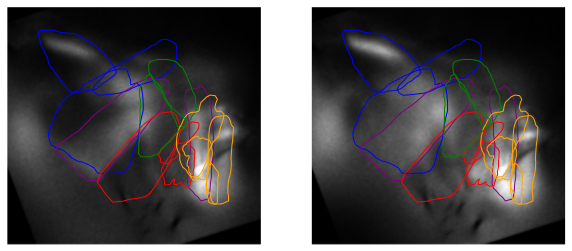

In [24]:
figure(figsize = (10,5))

gamma = lambda x: x**1.6
vmax = gamma(80)
confocal_model = mm.GeometricModel(filepath = '../imaging_post_processing/model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)
kwargs = {'draw_frame':False,
                        'frame_head_width':20,
                        'contour_kwargs':{'b1':{'edgecolor': 'b', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'b2':{'edgecolor': 'b', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'b3':{'edgecolor': 'b', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'i1':{'edgecolor': 'purple', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'i2':{'edgecolor': 'purple', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'iii1':{'edgecolor': 'r', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'iii24':{'edgecolor': 'r', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'iii3':{'edgecolor': 'r', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'hg1':{'edgecolor': 'orange', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'hg2':{'edgecolor': 'orange', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'hg3':{'edgecolor': 'orange', 'linewidth': 1.0, 'facecolor': 'none'},
                                          'hg4':{'edgecolor': 'orange', 'linewidth': 1.0, 'facecolor': 'none'},
                                         'tpd':{'edgecolor': 'g', 'linewidth': 1.0, 'facecolor': 'none'},
                                         'tpv':{'edgecolor': 'g', 'linewidth': 1.0, 'facecolor': 'none'},}}

subplot(1,2,1)
t = 59
img_idx = np.squeeze(np.argwhere(times>t))[0]
imshow(gamma(warp_fly_image(fly.fly_path,imgs[img_idx])),cmap = cm.gray,vmin = 0,vmax = vmax)
confocal_view.plot(confocal_model.frame,**kwargs)
kill_spines()

t = 59.6   
img_idx = np.squeeze(np.argwhere(times>t))[0]
subplot(1,2,2)
imshow(gamma(warp_fly_image(fly.fly_path,imgs[img_idx])),cmap = cm.gray,vmin = 0,vmax = vmax)
kill_spines()
confocal_view.plot(confocal_model.frame,**kwargs)
#show()
savefig('activation_comparison.pdf')

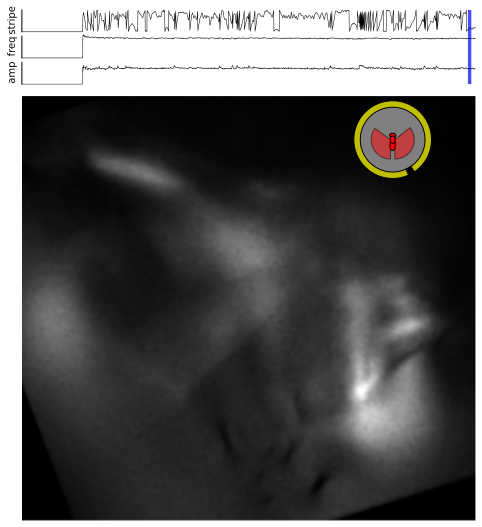

In [26]:
import numpy as np
w = 7
h = 8
aspect = w/float(h)
fig = plb.figure(figsize = (w,h))

plot_sigs = ['Xpos','wb_frequency','Ph1','b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4','tpv','tpd','ttm']

from matplotlib.gridspec import GridSpec
#gs = GridSpec(len(plot_sigs),10)

gs = GridSpec(20,20)
bkplot = fig.add_subplot(gs[:3,:])
kill_spines()

gamma = lambda x: x**1.6
vmax = gamma(80)

kwargs = {'color':'k','lw':0.5,'clip_on':False}

strt = 0
hlt_rng = [strt-0.3,strt+0.3]

ptch = plb.axvspan(hlt_rng[0],hlt_rng[1],lw =0,alpha = 0.7)
bkplot.set_xbound(0,80)

plotpans = [fig.add_subplot(gs[i,:]) for i in range(3)]

patch_list = list()
for i,pp,sig in zip(range(3),plotpans,plot_sigs):
    plb.axes(pp)
    if 'Ph1' in sig:
        plb.plot(times[trng],rwing_angles,**kwargs)
        frmt_axis(i,0,'amp',None)
    elif 'Xpos' in sig:
        plb.plot(times[trng],xpos,**kwargs)
        frmt_axis(i,0,'stripe',None)
    elif 'wb_frequency' in sig:
        plb.plot(times[trng],sigs[sig][trng],**kwargs)
        frmt_axis(i,0,'freq',None)
    else:
        try:
            plb.plot(times[trng],sigs[sig][trng],**kwargs)
            frmt_axis(i,0,sig,None)
        except KeyError:
            print i
[ax.set_xbound(0,80) for ax in plotpans]


img_idx = np.squeeze(np.argwhere(times[trng]>hlt_rng[0]))[0]

data_plot = plb.subplot(gs[3:,:])
data_img = gamma(imgs[img_idx])
data_img = warp_fly_image(fly.fly_path,data_img)
data_img_handle = plb.imshow(data_img,cmap = plb.cm.gray,vmin = 0,vmax = vmax)
kill_spines()

fig.subplots_adjust(subplots_adjust(bottom=0.05, right=0.95, top=0.95,left =0.05))

ptch_start = ptch.xy[:,0].copy()

#####
#####
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
fly_diagram = dict()
inset_axes = fig.add_axes([.70,.65,.15/aspect,.15])

wing_len = 9.0
theta_r = pi/4
theta_l = pi/4.3
stripe_center = 90
swidth = 3
arena_rad = 2*wing_len 
base = mpatches.Circle((0,0),arena_rad - swidth,facecolor = 'gray')
panels = mpatches.Circle((0,0),arena_rad,facecolor = 'y')
body = mpatches.Ellipse((0,0),2.5,3.5,facecolor = 'r')
abdomin = mpatches.Ellipse((0,-2.5),3,5,facecolor = 'r')
head = mpatches.Ellipse((0,2.0),3,2,facecolor = 'r')
stripe = mpatches.Wedge((0,0),arena_rad,stripe_center-5,stripe_center+5,width = swidth,color = 'k')
rwing = mpatches.Wedge((1,0),wing_len,-90,rad2deg(theta_r),alpha = 0.5,facecolor = 'r')
lwing = mpatches.Wedge((-1,0),wing_len,180-rad2deg(theta_l),-90,alpha = 0.5,facecolor = 'r')
fly_diagram.update({'base':base,'panels':panels,
                    'body':body,'abdomin':abdomin,
                    'head':head,'stripe':stripe,
                    'rwing':rwing,'lwing':lwing})

inset_axes.add_patch(panels)
inset_axes.add_patch(base)
inset_axes.add_patch(abdomin)
inset_axes.add_patch(head)
inset_axes.add_patch(body)
inset_axes.add_patch(rwing)
inset_axes.add_patch(lwing)
inset_axes.add_patch(stripe)
kill_spines()
gca().set_xbound(-20,20)
gca().set_ybound(-20,20)
#

def update_fig(t):
    #print t
    idx = np.squeeze(np.argwhere(times[trng]>t))[0]
    theta_l,theta_r,stripe_center,frame = lwing_angles[idx],rwing_angles[idx],xpos[idx],imgs[idx]
    ptch.xy[:,0] = ptch_start+t
    data_img = gamma(frame)
    data_img = warp_fly_image(fly.fly_path,data_img)
    data_img_handle.set_data(data_img)

    #model_img = gamma((np.dot(model.T,fits_reconst[:,trng][:,idx]).reshape(np.shape(imgs[0]))*baseln)+baseln)
    #model_img = warp_fly_image(fly.fly_path,model_img)
    #model_img_handle.set_data(model_img)
    
    stripe_center = rad2deg(stripe_center)+(180-rad2deg(stripe_center))*2
    rwing.set_theta2(theta_r)
    lwing.set_theta1(180-theta_l)
    stripe.set_theta1(stripe_center-5)
    stripe.set_theta2(stripe_center+5)

update_fig(0.0)

import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter 
Writer = FFMpegWriter 
writer = Writer(fps=30, metadata=dict(artist='Theodore Lindsay'), bitrate=1800)

ani = animation.FuncAnimation(fig, update_fig, frames=np.arange(0.0,79.0,1/30.0), blit=False)
ani.save('tuning_maps.mp4', writer=writer)
